# Task Aggiuntivo Hackathon Randstad Carta Geografica

In [15]:
import pandas as pd

# import the data
df = pd.read_excel("data_geomap_total.xlsx")


In [16]:
# plot the dataframe shape for exìploration purposes
df.shape

(430839, 2)

In [17]:
df.head()

,City_Nation,Reviewer_Score
0,"Vienna, Austria",8.3
1,"Vienna, Austria",2.5
2,"Vienna, Austria",5.8
3,"Vienna, Austria",7.0
4,"Vienna, Austria",10.0


In [18]:
# plot data description
df.describe()

,Reviewer_Score
count,430839.000000
mean,8.383977
std,1.685462
min,2.500000
25%,7.500000
50%,9.200000
75%,9.600000
max,10.000000


In [19]:
df["City_Nation"].value_counts()

,count
City_Nation,
"London, United Kingdom",220360
"Barcelona, Spain",50663
"Paris, France",49031
"Amsterdam, Netherlands",48449
"Vienna, Austria",32117
"Milan, Italy",30219


In [20]:
# obtain a list of cities
cities = df["City_Nation"].unique()

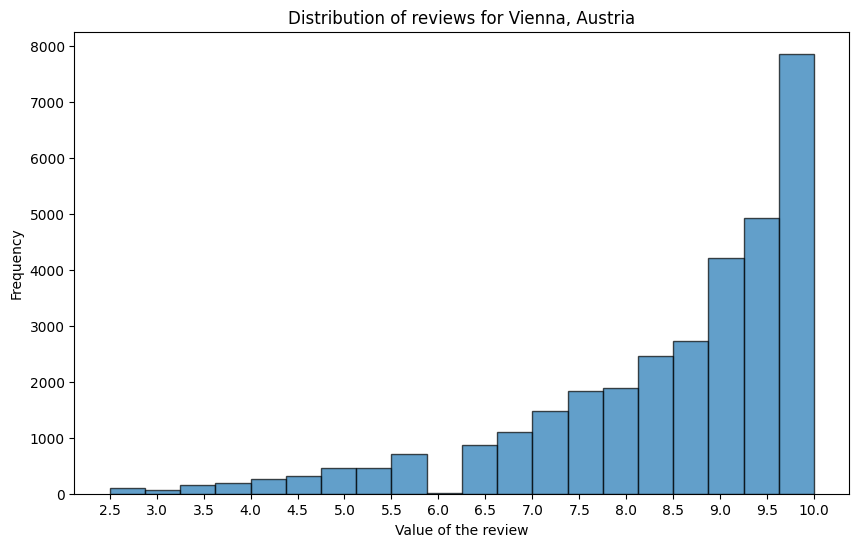

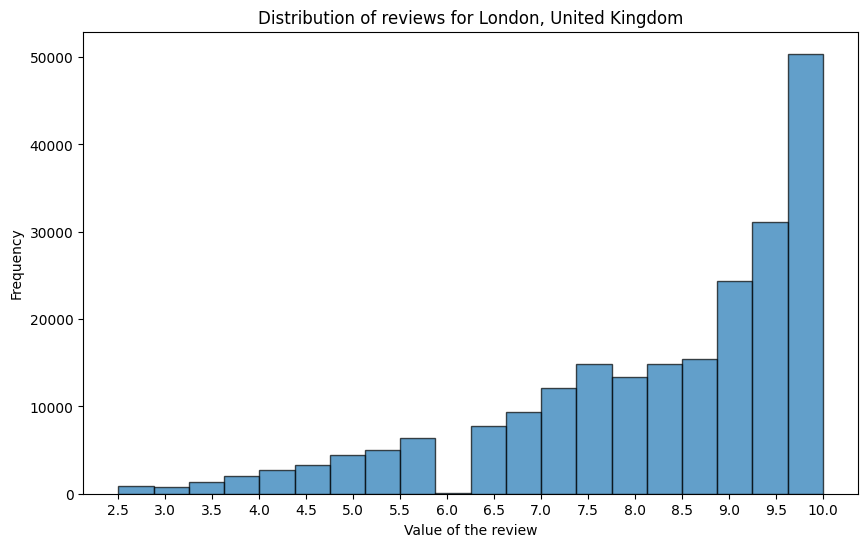

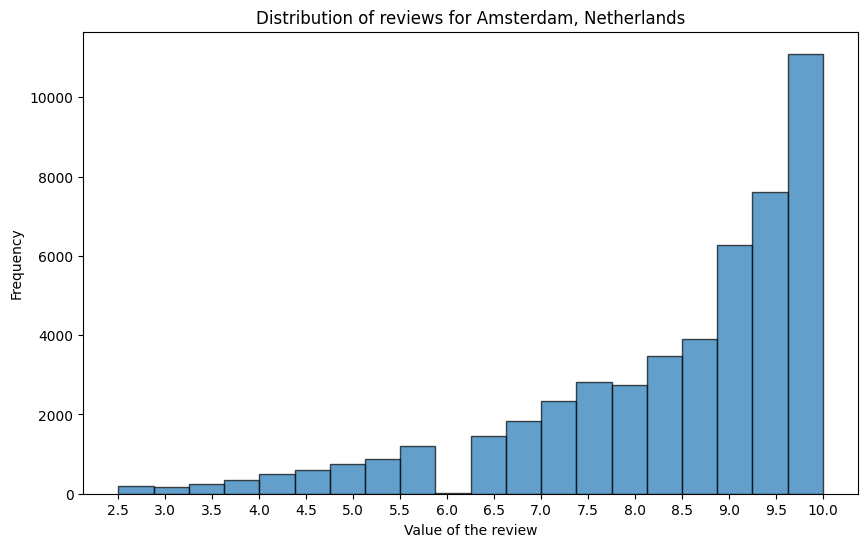

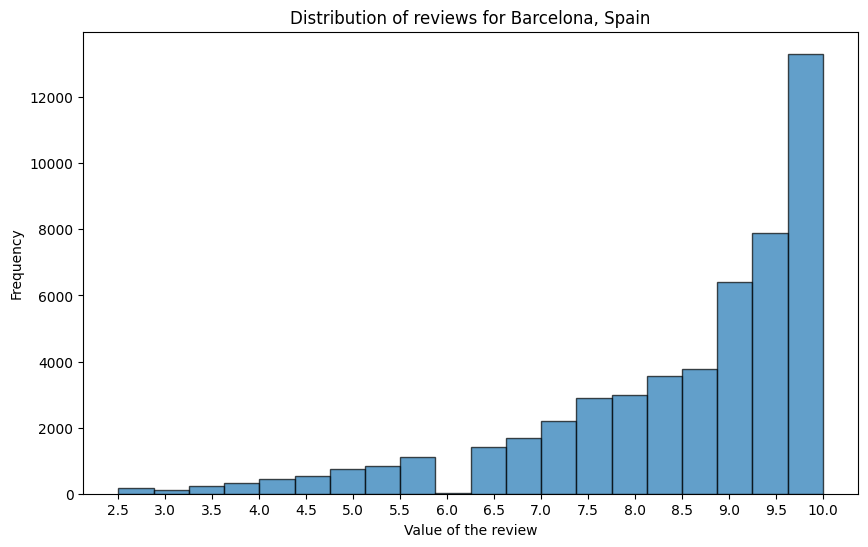

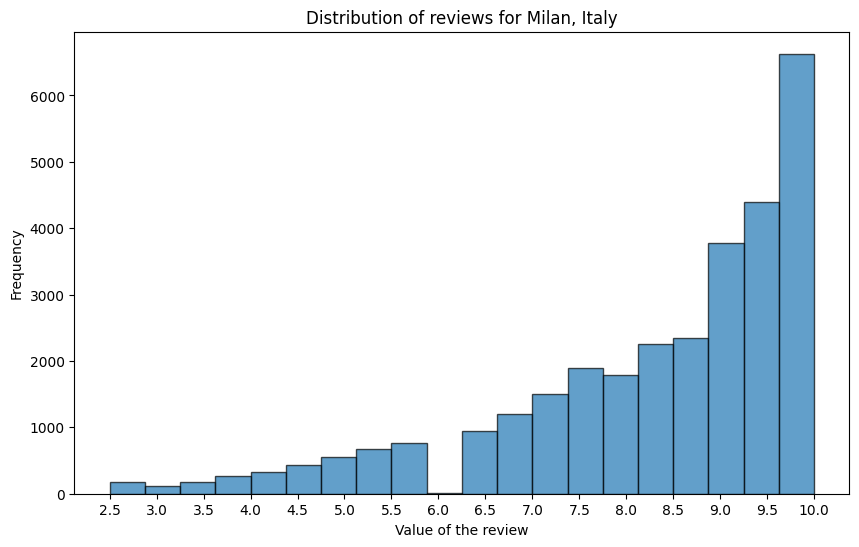

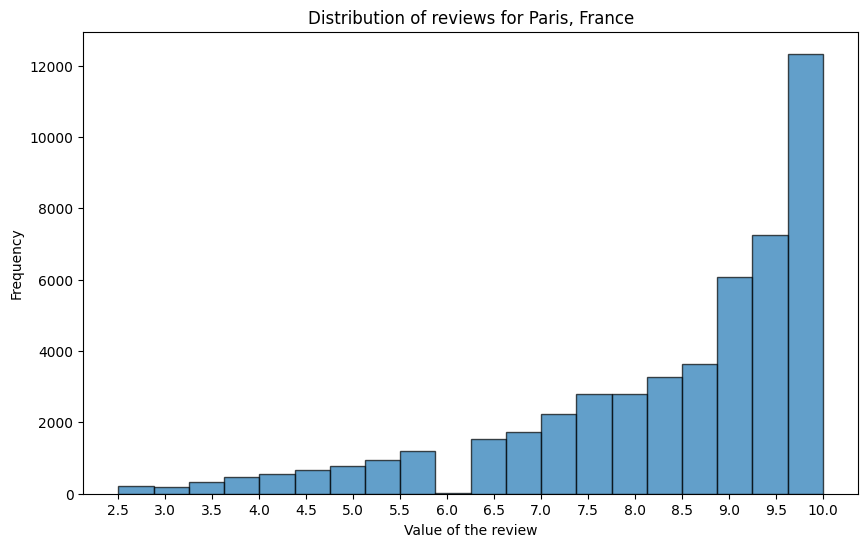

In [39]:
import matplotlib.pyplot as plt
# for each city plot a histogram describing the distribution of the reviews
for city in cities:
  city_df = df[df["City_Nation"] == city]
  # Plot the distribution of the number of reviews
  plt.figure(figsize=(10, 6))
  plt.hist(city_df["Reviewer_Score"], bins=20, edgecolor='black', alpha=0.7)

  # Set x-axis ticks with intermediate values
  min_score = min(city_df["Reviewer_Score"])
  max_score = max(city_df["Reviewer_Score"])
  plt.xticks([x * 0.5 for x in range(int(min_score * 2), int(max_score * 2) + 1)])

  plt.title(f'Distribution of reviews for {city}')
  plt.xlabel('Value of the review')
  plt.ylabel('Frequency')
  name = city.split(", ")[0]
  # save the histogram to embed it into the HTML map
  plt.savefig(f"histogram_{name}.png")
  plt.show()



In [22]:
# plot the map of each city showing the mean

from geopy.geocoders import Nominatim
# Initialize the geodecoder
geolocator = Nominatim(user_agent="hackathon_agent")
# Function to obtain the coordinates of a city or a country
def get_coordinates(place_name):
    location = geolocator.geocode(place_name)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

rating_stats = df.groupby('City_Nation', as_index=False)['Reviewer_Score'].agg(
    Average_Rating='mean',
    Median_Rating='median'
)

rating_stats['Coordinates'] = None
for i,row in rating_stats.iterrows():
  rating_stats['Coordinates'][i] = get_coordinates(row['City_Nation'])

rating_stats

# since the mean is negatively influenced by outliers, we will use the median

<ipython-input-22-b539ddb6a4ba>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  rating_stats['Coordinates'][i] = get_coordinates(row['City_Nation'])
<ipython-input-22-b539ddb6a4ba>:21: SettingWithCopyWarning: 
A value is trying to be set o

,City_Nation,Average_Rating,Median_Rating,Coordinates
0,"Amsterdam, Netherlands",8.448300,9.2,"(52.3730796, 4.8924534)"
1,"Barcelona, Spain",8.557794,9.2,"(41.3828939, 2.1774322)"
2,"London, United Kingdom",8.301240,8.8,"(51.4893335, -0.14405508452768728)"
3,"Milan, Italy",8.340484,8.8,"(45.4641943, 9.1896346)"
4,"Paris, France",8.434456,9.2,"(48.8534951, 2.3483915)"
5,"Vienna, Austria",8.544291,9.2,"(48.2083537, 16.3725042)"


In [8]:
import folium

# Create the map
mappa = folium.Map(location=[50,10], zoom_start=4)

# iterate on the rows fo the datframe
for index, row in rating_stats.iterrows():
  lat = row["Coordinates"][0]
  lon = row["Coordinates"][1]
  avg = row["Average_Rating"]
  med = row["Median_Rating"]

  folium.Marker(
      location = [lat, lon],
      popup=f"Average score: {avg}",
      icon=folium.Icon(color="green")
  ).add_to(mappa)

mappa


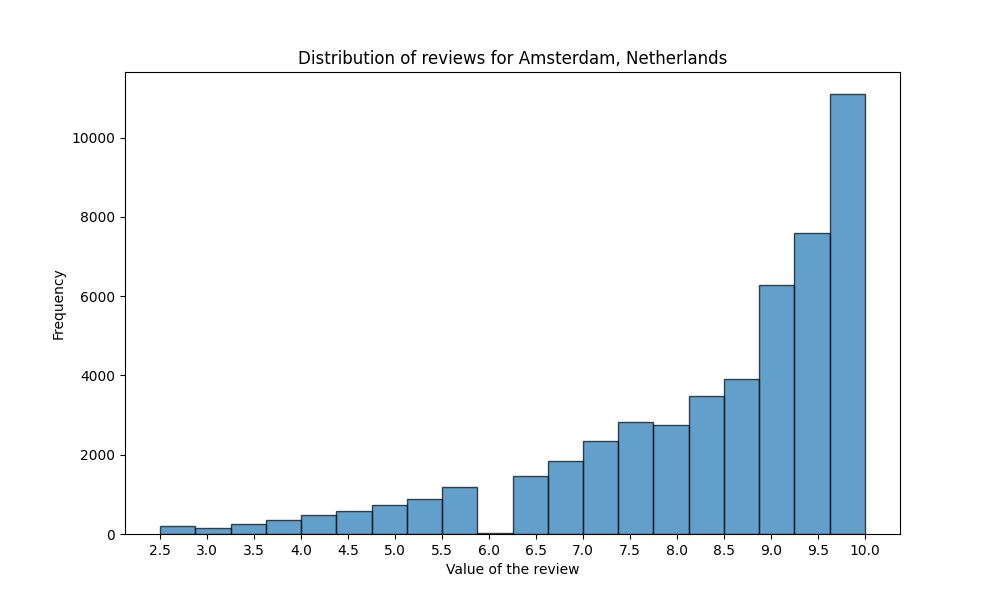
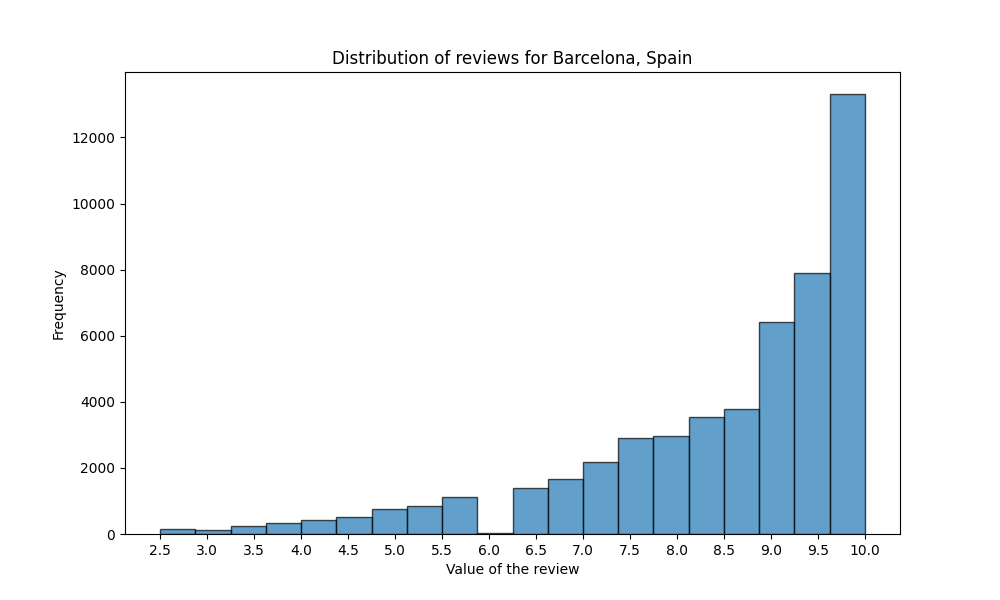
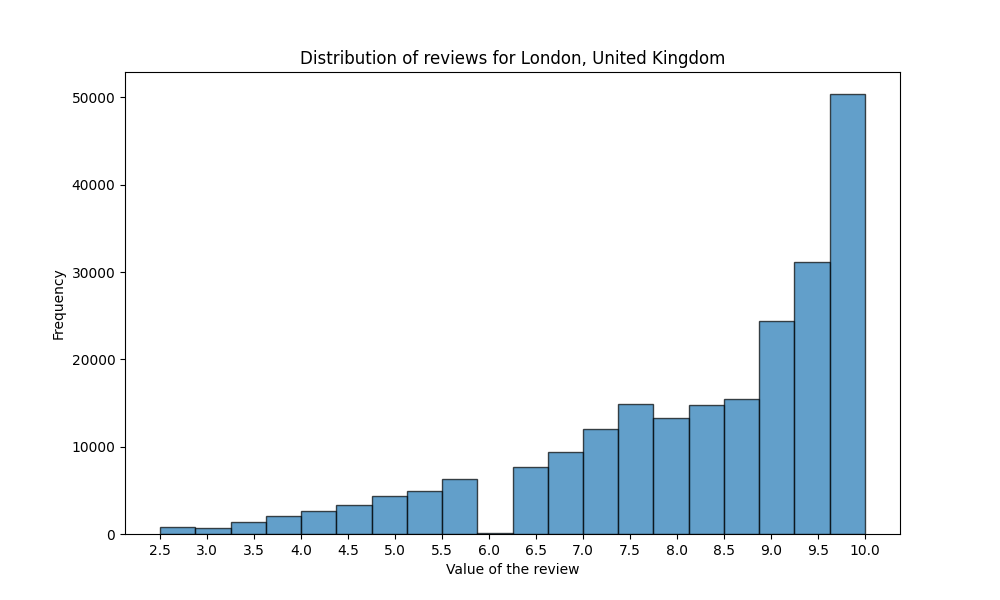
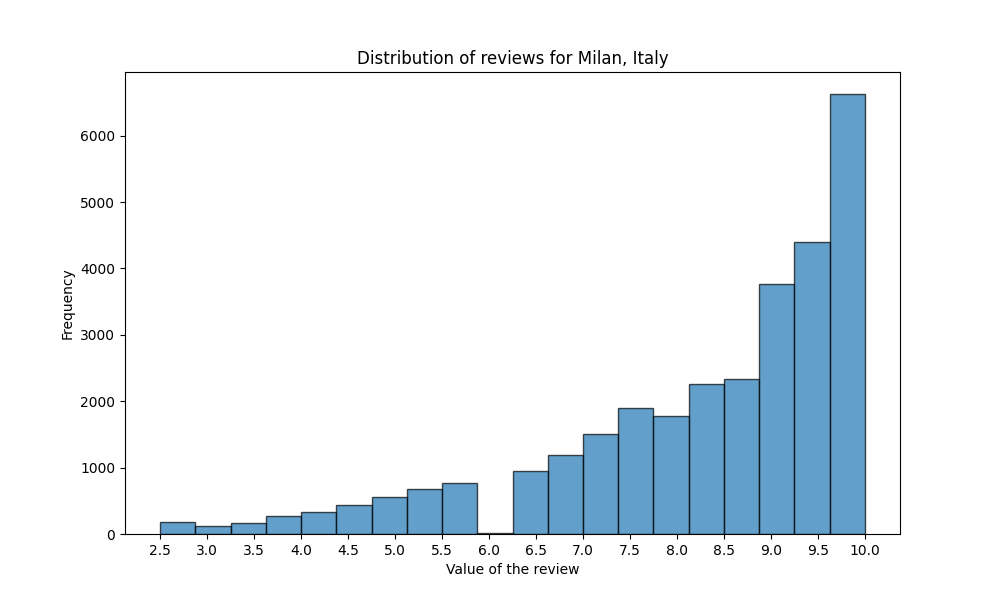
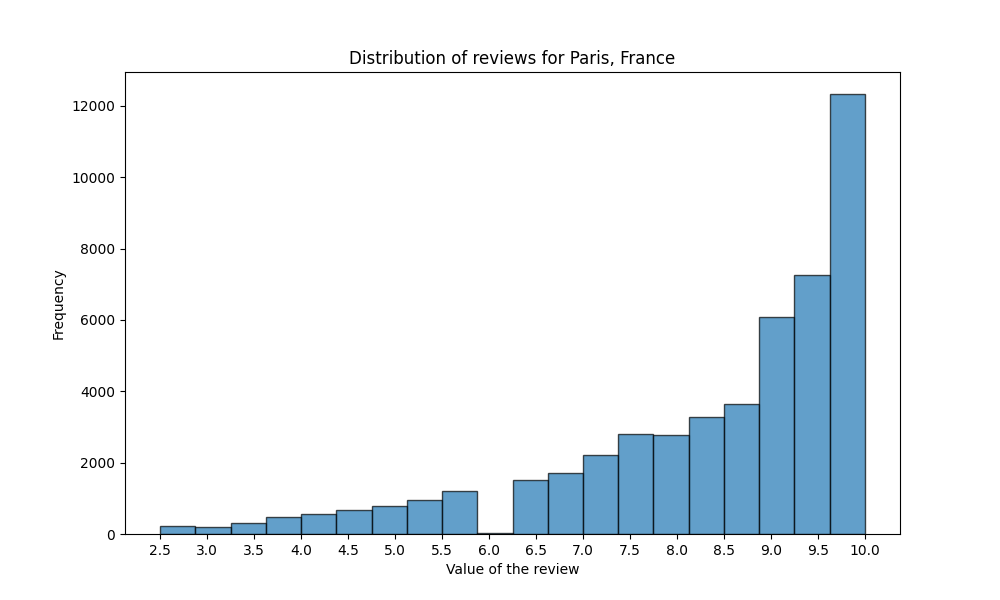
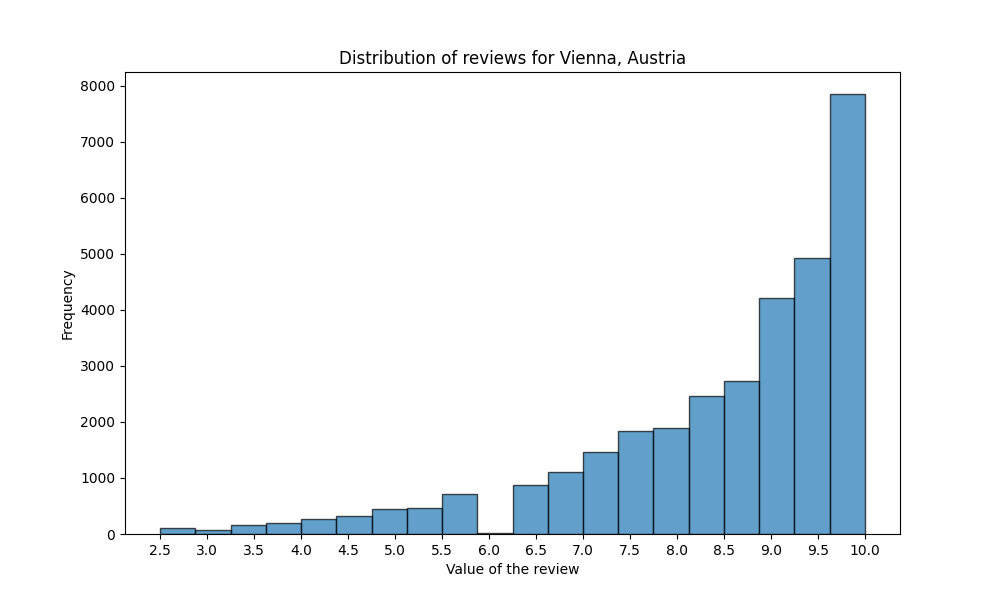

In [40]:
import folium
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import base64

# Create the map
mappa = folium.Map(location=[50,10], zoom_start=4)

def img_to_base64(img_path):
  with open(img_path, 'rb') as f:
    return base64.b64encode(f.read()).decode('utf-8')


# iterate on the rows of the dataframe
for index, row in rating_stats.iterrows():
    lat = row["Coordinates"][0]
    lon = row["Coordinates"][1]
    avg = row["Average_Rating"]
    med = row["Median_Rating"]
    name = row["City_Nation"].split(",")[0]
    # Convert the image to base64 to embed it into the popup
    img_base64 = img_to_base64(f"histogram_{name}.png")
    # Create the HTML content for the popup
    popup_html = f"""
<h4>Average Rating: {avg}</h4>
<h4>Median Rating: {med}</h4>
<img src="data:image/png;base64,{img_base64}" width="200">
    """
    # Add the marker to the map
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=300),
        icon=folium.Icon(color="green")
    ).add_to(mappa)

# Visualize the map
mappa

#Additional Considerations
In the map we reported the average rating, but since it is **negatively influenced by the outlier**s, we have decided to integrate also the **median** that is a more robust estimator. Moreover, we embedded also a **histogram** describing the trend of the reviews, to know in a comprehensive way the distribution of the reviews for each city.